In [14]:
import pandas as pd
import tensorflow as tf

# Load the dataset CSV
df = pd.read_csv('/Users/nithish/Documents/Academics/Spring 24/AML/project/samplePreprocessedData.csv')
train_df = df[df['usage'] == 'train']
val_df = df[df['usage'] == 'validate']

drop_index = train_df[train_df['filename'] == 'image_00006_Debris_2021.jpg'].index.tolist()
train_df.drop(drop_index, axis = 0, inplace=True)

# Convert filenames and labels into lists for TensorFlow Dataset
train_image_paths = ['/Users/nithish/Documents/Academics/Spring 24/AML/project/data/preprocessed_data/train/' + fname for fname in train_df['filename']]
train_labels = train_df['class'].tolist()

val_image_paths = ['/Users/nithish/Documents/Academics/Spring 24/AML/project/data/preprocessed_data/validate/' + fname for fname in val_df['filename']]
val_labels = val_df['class'].tolist()

train_df['class'].value_counts()


/var/folders/nz/x14sy1sd2rj_6ltfxbm014780000gn/T/ipykernel_15051/1906872134.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(drop_index, axis = 0, inplace=True)


class
0.0    3799
1.0    3769
Name: count, dtype: int64

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMG_SIZE = (128, 128)  # Define the image size

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize to [0, 1]
    return img

def load_and_preprocess(image_path, label):
    return preprocess_image(image_path), label

def create_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create training and validation datasets
train_ds = create_dataset(train_image_paths, train_labels)
val_ds = create_dataset(val_image_paths, val_labels)


2024-04-18 08:58:59.992059: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-18 08:58:59.992085: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-18 08:58:59.992089: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-18 08:58:59.992134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 08:58:59.992149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # tf.keras.layers.BatchNormalization(),
    # Add a dropout layer to reduce overfitting
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    # Add L2 regularization to the dense layer
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5), # Additional dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define the initial learning rate and the exponential decay rate
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds
)


Epoch 1/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.6506 - loss: 0.7581 - val_accuracy: 0.6805 - val_loss: 0.6287
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.7171 - loss: 0.5997 - val_accuracy: 0.7089 - val_loss: 0.6071
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.7433 - loss: 0.5641 - val_accuracy: 0.7118 - val_loss: 0.5998
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.7731 - loss: 0.5422 - val_accuracy: 0.7290 - val_loss: 0.5827
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8008 - loss: 0.5183 - val_accuracy: 0.7533 - val_loss: 0.5686
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8035 - loss: 0.5080 - val_accuracy: 0.7792 - val_loss: 0.5594
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8301 - loss: 0.4695 - val_accuracy: 0.7989 - val_loss: 0.5341
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8488 - loss: 0.4511 - val_accu

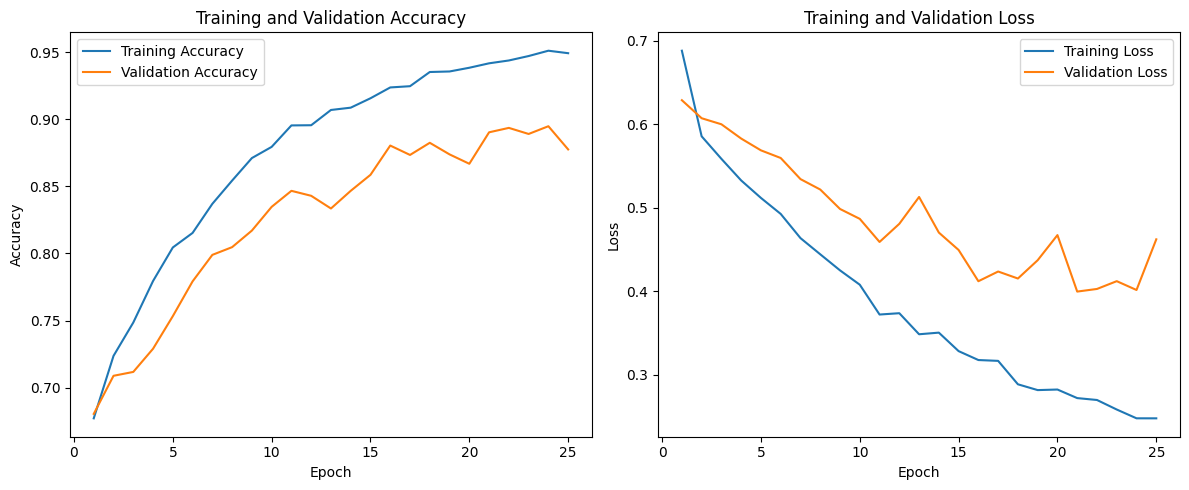

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with your model's history
plot_training_history(history)
